In [1]:
#Import packages
import pandas as pd
import numpy as np
import glob

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
cm = 1/2.54  # centimeters in inches

In [ ]:
data_ML = pd.read_csv('..\data\database_preprocessed_2024_soilparameter.csv')
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
0,1.80,0.289,19.0,6.574394,37.0,10.370000,NaN,1.830000,NaN,Bergambacht (B06 51B)
1,1.86,0.289,19.0,6.574394,37.0,10.390000,NaN,NaN,NaN,Bergambacht (B06 51C)
2,2.71,0.257,14.0,5.447471,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52B)
3,2.76,0.257,14.0,5.447471,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52C)
4,1.35,0.226,11.0,4.867257,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52D)
...,...,...,...,...,...,...,...,...,...,...
785,4.55,0.480,7.5,1.562500,304.8,17.849941,2.203390,2.058824,NaN,Austria_site5
786,4.55,0.480,7.5,1.562500,304.8,16.930067,1.950510,2.156863,NaN,Austria_site5
787,4.55,0.480,7.5,1.562500,304.8,16.900000,NaN,NaN,NaN,Austria_site5
788,4.65,0.490,7.7,1.571429,308.8,17.237443,2.076677,1.960784,NaN,Austria_site5


In [4]:
prefix = r'..\graphics\\'
investigated_column =  ['gamma (kN/m3)', 'su (kPa)', 'M (MN/m2)', 'OCR (-)']
investigated_column_plot =  ['$\gamma$ (kN/m$^3$)', '$s_u$ (kPa)', 'M (MN/m$^2$)', 'OCR (-)']
save_paths = [prefix + '1_gamma_prediction.png', prefix + '2_su_prediction.png', prefix + '3_M_prediction.png']
axis_limit = [(13, 22), (0, 200), (0, 20), (0,20)]

j = 1
investigated_column_plot = investigated_column_plot[j]
investigated_column = investigated_column[j]
save_path = save_paths[j]

data_ML = data_ML.dropna(subset=[investigated_column])
print(f"{investigated_column} is selected to predict, {investigated_column_plot} is plotted, {save_path} is saved, {axis_limit[j]} is the axis limit, {len(data_ML)} is the length of the data")

#Remove the NGTS data from silt and clay test sites
data_ML_filtered = data_ML[~data_ML['sampling_name(-)'].str.contains(r'NGTS_Silt_|NGTS_Clay_', na=False)]

columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)'] #for plotting purpose

X = data_ML_filtered.loc[:,columns_x]
y = data_ML_filtered[investigated_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

su (kPa) is selected to predict, $s_u$ (kPa) is plotted, ..\graphics\\2_su_prediction.png is saved, (0, 200) is the axis limit, 257 is the length of the data


In [5]:
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
30,15.250,0.219,8.000,3.652968,5.000,13.16,NaN,NaN,18.5,Full Scale Damwand Proef Eemdijk (B27 65)
36,10.050,0.409,23.000,5.623472,-9.000,13.60,NaN,NaN,52.3,Full Scale Damwand Proef Eemdijk (B31 8)
40,5.650,0.107,2.000,1.869159,-4.000,12.99,NaN,NaN,6.4,Full Scale Damwand Proef Eemdijk (B33 252)
83,4.350,0.377,18.000,4.774536,15.000,11.59,NaN,NaN,38.0,Delft (603 12a)
86,1.700,0.314,7.000,2.229299,147.000,12.40,NaN,NaN,46.0,Bergambacht (B07 42E)
...,...,...,...,...,...,...,...,...,...,...
700,12.495,0.899,18.160,2.020022,318.630,19.56,NaN,NaN,57.9,NGTS_Silt_HALB05
703,8.315,0.768,17.893,2.329818,183.133,19.65,NaN,NaN,40.3,NGTS_Silt_HALB06
705,8.645,0.848,19.268,2.272170,176.950,19.10,NaN,NaN,11.7,NGTS_Silt_HALB06
708,9.925,0.815,17.350,2.128834,227.794,19.70,NaN,NaN,44.0,NGTS_Silt_HALB06


In [6]:
data_ML = data_ML_filtered
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
30,15.25,0.219000,8.000000,3.652968,5.000000,13.16,NaN,NaN,18.5,Full Scale Damwand Proef Eemdijk (B27 65)
36,10.05,0.409000,23.000000,5.623472,-9.000000,13.60,NaN,NaN,52.3,Full Scale Damwand Proef Eemdijk (B31 8)
40,5.65,0.107000,2.000000,1.869159,-4.000000,12.99,NaN,NaN,6.4,Full Scale Damwand Proef Eemdijk (B33 252)
83,4.35,0.377000,18.000000,4.774536,15.000000,11.59,NaN,NaN,38.0,Delft (603 12a)
86,1.70,0.314000,7.000000,2.229299,147.000000,12.40,NaN,NaN,46.0,Bergambacht (B07 42E)
...,...,...,...,...,...,...,...,...,...,...
386,6.87,0.255222,8.444444,3.308663,203.000000,14.21,NaN,NaN,20.8,Ballina_Mex 9
387,7.75,0.277444,8.666667,3.123748,203.222222,14.10,NaN,NaN,17.7,Ballina_Mex 9
388,7.93,0.280667,8.666667,3.087886,223.777778,14.31,NaN,NaN,17.0,Ballina_Mex 9
391,9.73,0.331222,10.222222,3.086213,249.666667,14.96,NaN,NaN,26.3,Ballina_Mex 9


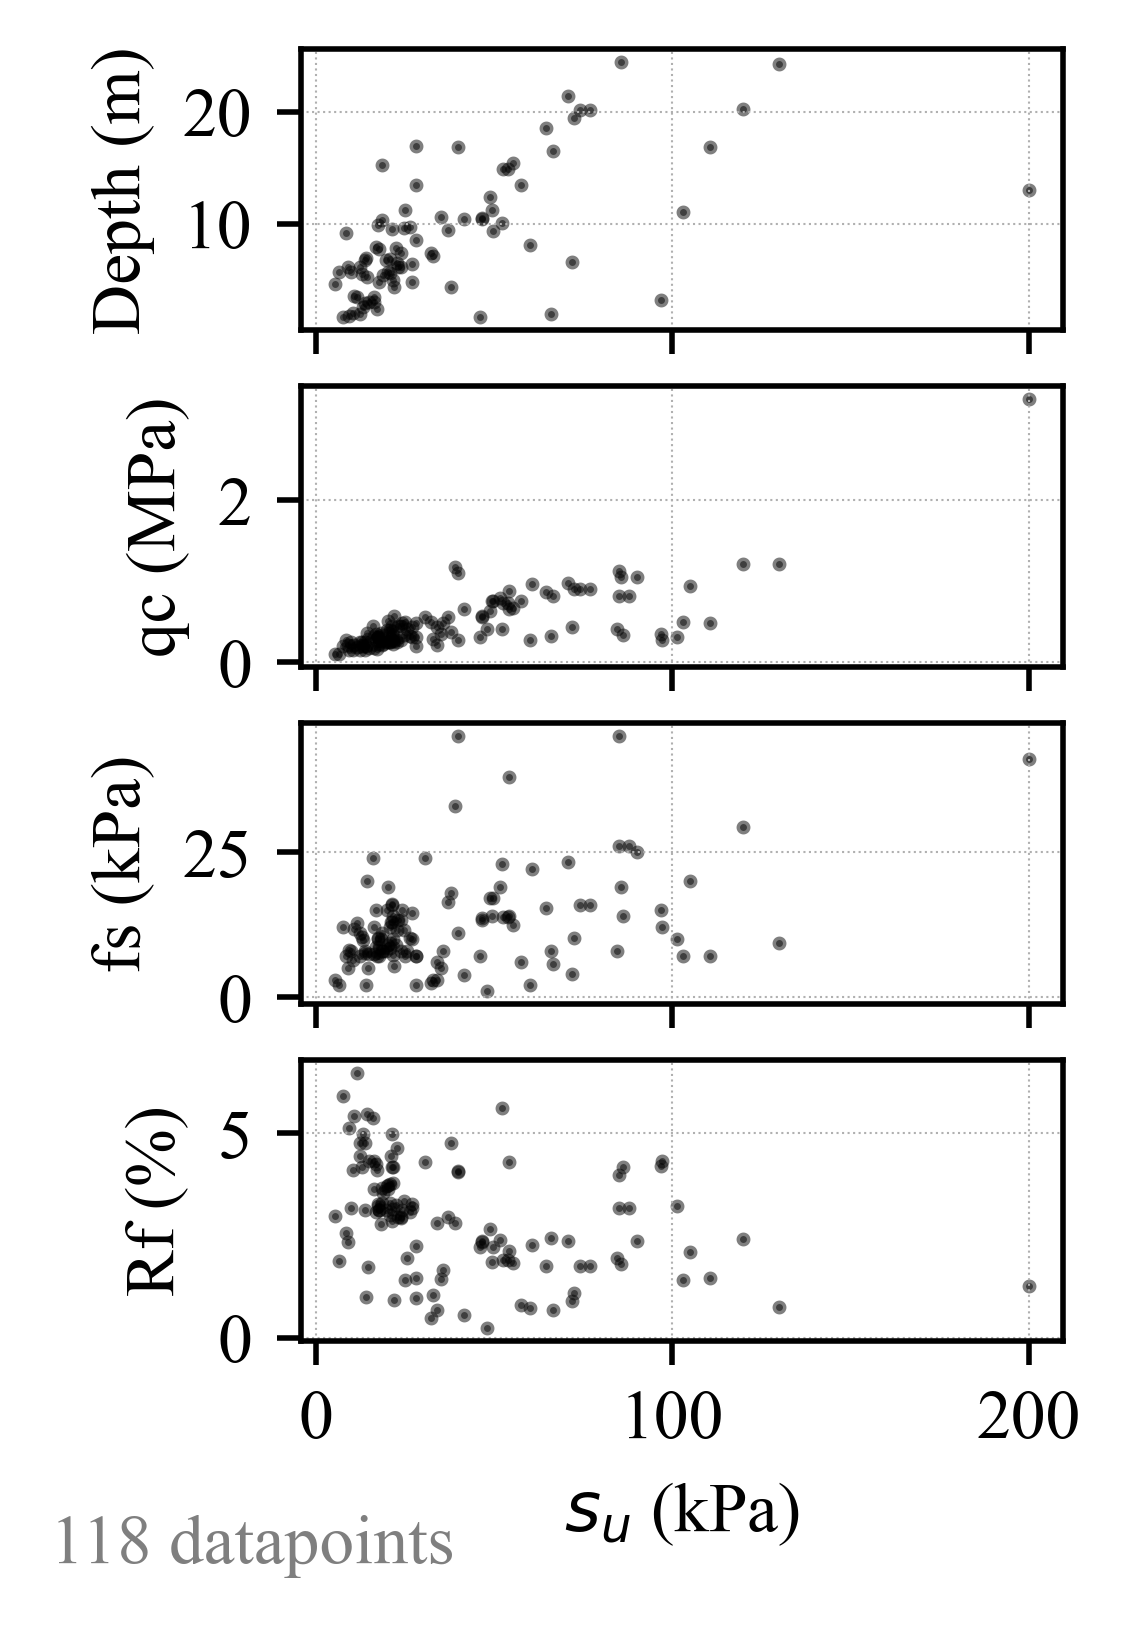

In [17]:
# Plotting training data 
s = 1  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 0.5

columns_x.append(investigated_column_plot)

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(15.92/3*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, columns_x, 'Raw data', False)

# Adjust layout to prevent overlapping
fig.text(0.01, 0.02, rf'{len(data_ML)} datapoints', ha='left', va='center', fontsize=10, color='black', alpha=0.5)
plt.subplots_adjust(left=0.25, right=0.98, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig(f"{prefix}{j+1}_raw_data.png", dpi = 1000)

In [8]:
RS = 44  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# Optuna
N_TRIALS = 200

# XGBoost
EARLY_STOPPING_ROUNDS = 10

In [9]:
def objective(trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
              ):
    
    param = {
        "objective": "reg:squarederror",
        "tree_method":'hist',
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 0.9,log=True),
        "n_jobs": n_jobs,
    }
    
    model = xgb.XGBRegressor(**param, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)

    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose=0,)
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    r2 = r2_score(y_true = y_train, y_pred = y_pred)
    
    return r2


sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler = sampler, direction='maximize')
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=RS,
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        n_jobs=N_JOBS,
    ),
    n_trials=N_TRIALS,
    n_jobs=N_JOBS,
)

[I 2024-11-20 21:07:26,260] A new study created in memory with name: no-name-7c1d440c-69a9-4c4d-b7c2-fa1ce30c2a8f
[I 2024-11-20 21:07:26,762] Trial 5 finished with value: 0.4478610015941552 and parameters: {'n_estimators': 105, 'learning_rate': 0.4156166745508077, 'max_depth': 10, 'subsample': 0.16891696514372223}. Best is trial 5 with value: 0.4478610015941552.
[I 2024-11-20 21:07:26,787] Trial 4 finished with value: 0.44643650704941673 and parameters: {'n_estimators': 53, 'learning_rate': 0.3329681807651409, 'max_depth': 8, 'subsample': 0.4175765820008519}. Best is trial 5 with value: 0.4478610015941552.
[I 2024-11-20 21:07:26,848] Trial 3 finished with value: 0.35633324107832254 and parameters: {'n_estimators': 59, 'learning_rate': 0.09239808875294435, 'max_depth': 4, 'subsample': 0.07655506346536953}. Best is trial 5 with value: 0.4478610015941552.
[I 2024-11-20 21:07:26,879] Trial 0 finished with value: 0.46442507376406605 and parameters: {'n_estimators': 68, 'learning_rate': 0.16

In [10]:
# Plot optimization history
plot_optimization_history(study)

In [11]:
# Plot parameter importances
plot_param_importances(study)

In [12]:
hp = study.best_params

for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["tree_method"] = "hist"
hp["seed"] = RS
hp["n_jobs"] = N_JOBS

        n_estimators : 54
       learning_rate : 0.21656322182320809
           max_depth : 10
           subsample : 0.1652472013127238
best objective value : 0.5501821521748056


In [13]:
model = xgb.XGBRegressor(**hp, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= N_REPEATS * N_SPLITS

In [14]:
score, mse = r2_score(y_true=y_test, y_pred=y_pred), mean_squared_error(y_true=y_test, y_pred=y_pred)

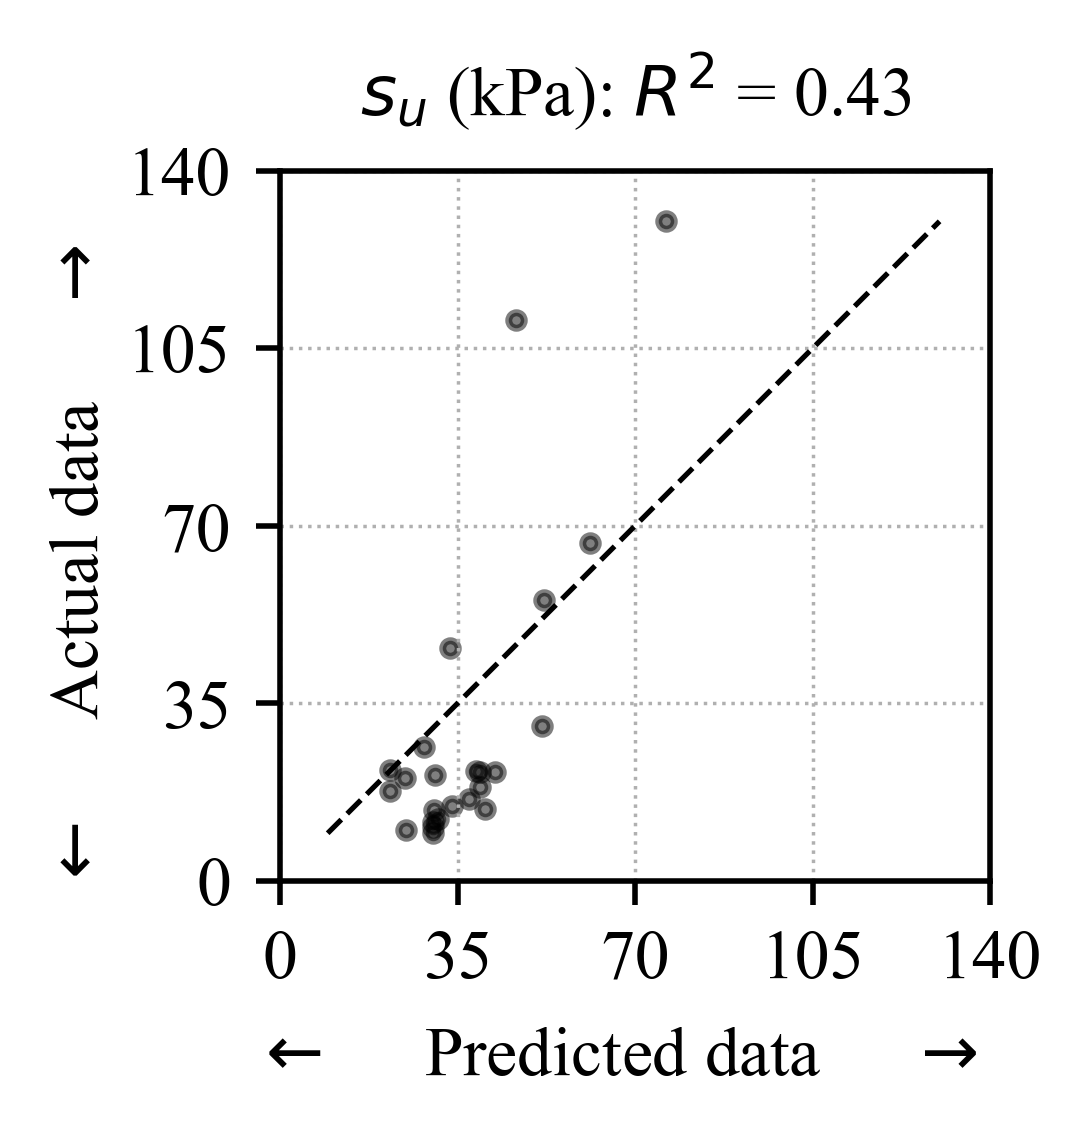

In [20]:
from sklearn.metrics import PredictionErrorDisplay

figsize= (15.5/2*cm, 15.5/2*cm)
figsize=(15.92/3*cm, 15.92/3*cm)

y_true = y_test
y_pred = pd.DataFrame(y_pred)


# Define plot structure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=500)

ped = PredictionErrorDisplay.from_predictions(y_true=y_true,
                                            y_pred=y_pred,
                                            kind="actual_vs_predicted",
                                            subsample=100000,
                                            ax=axs,
                                            random_state=0, 
                                            line_kwargs={"color": "black", "linewidth": 0.75, "linestyle": "--", "alpha": 1},)

ped.ax_.set_xlabel("")  # Set x label
ped.ax_.set_ylabel("")  # Set y label

xlim, ylim = axis_limit[j][0], axis_limit[j][1]/2+40

ped.ax_.set_xticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_yticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
# ped.ax_.set_xlim(xlim+0.001, ylim-0.001)
# ped.ax_.set_ylim(xlim+0.001, ylim-0.001)


ped.ax_.grid(linewidth = 0.5, linestyle = 'dotted')

scatter = ped.figure_.axes[0].collections[0]
scatter.set_color('black')  
scatter.set_sizes([5]) 
scatter.set_alpha([0.5]) 

# plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}, $MSE$ = {mse:.2f}', x = 0.41, y=1.02)
plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}', x = 0.5, y=1.02)

ax = ped.ax_
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=0)

fig.text(0.55, 0.03, r'$\leftarrow$     Predicted data     $\rightarrow$', ha='center', va='center')
fig.text(0.04, 0.5, r'$\leftarrow$     Actual data     $\rightarrow$', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=0.23, right=0.91, top=0.88, bottom=0.20, wspace=0.5, hspace=0.5)
plt.savefig(save_path, dpi=1000)

In [16]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**hp, eval_metric="rmse", random_state=RS)

# Fit the model on the entire dataset
final_model.fit(X, y)

name = save_path.split('\\')[-1].split('.')[0]
joblib.dump(final_model, f'{name}_xgb_model.joblib')


['2_su_prediction_xgb_model.joblib']